# Synthetic Circular Graph Data Generation - Ring with Sinusoidal Signal

This notebook generates synthetic data on a circular graph where graph proximity corresponds to function similarity for testing graph-based interpolation methods.

**Key Features:**
- Circular graph structure (ring) with k-nearest neighbors
- Sinusoidal signal that respects graph topology
- Graph neighbors have similar function values (good for interpolation)
- Consistent node indexing for graph-based methods
- Random sparse sampling for training data
- Same data structure as wind interpolation example

In [1]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx
import time

# Configuration
N_NODES = 10000         # Total number of nodes (10K for manageable computation)
K_NEIGHBORS = 4         # Number of nearest neighbors in each direction (total degree = 2*K)
TRAINING_RATIO = 0.01   # 1% of nodes for training
NOISE_STD = 0.1         # Standard deviation of noise
N_FREQUENCIES = 3       # Number of sinusoidal components
RANDOM_SEED = 42        # For reproducibility

np.random.seed(RANDOM_SEED)

print(f"Configuration:")
print(f"  Total nodes: {N_NODES:,}")
print(f"  K-nearest neighbors: {K_NEIGHBORS} (degree = {2*K_NEIGHBORS})")
print(f"  Number of frequencies: {N_FREQUENCIES}")
print(f"  Training ratio: {TRAINING_RATIO*100:.1f}%")
print(f"  Expected training points: {int(N_NODES * TRAINING_RATIO):,}")
print(f"  Noise std: {NOISE_STD}")
print(f"  Random seed: {RANDOM_SEED}")

Configuration:
  Total nodes: 10,000
  K-nearest neighbors: 4 (degree = 8)
  Number of frequencies: 3
  Training ratio: 1.0%
  Expected training points: 100
  Noise std: 0.1
  Random seed: 42


In [2]:
# =============================================================================
# CIRCULAR GRAPH CONSTRUCTION
# =============================================================================

def build_circular_graph(n_nodes, k_neighbors):
    """
    Build a circular graph (ring) with k-nearest neighbors
    
    Parameters:
    -----------
    n_nodes : int
        Number of nodes
    k_neighbors : int
        Number of neighbors in each direction (total degree = 2*k)
        
    Returns:
    --------
    A : scipy.sparse.csr_matrix
        Adjacency matrix
    """
    rows, cols, data = [], [], []
    
    # Connect each node to k neighbors on each side in the ring
    for i in range(n_nodes):
        for k in range(1, k_neighbors + 1):
            # Forward neighbors (with wraparound)
            j_forward = (i + k) % n_nodes
            # Backward neighbors (with wraparound)  
            j_backward = (i - k) % n_nodes
            
            # Add both directions for undirected graph
            rows.extend([i, i])
            cols.extend([j_forward, j_backward])
            data.extend([1.0, 1.0])
    
    A = sparse.coo_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes))
    return A.tocsr()

def generate_circular_sinusoidal_function(n_nodes, n_frequencies=3, noise_std=0.1):
    """
    Generate sinusoidal function values that respect circular graph topology
    
    Parameters:
    -----------
    n_nodes : int
        Number of nodes
    n_frequencies : int
        Number of sinusoidal frequency components
    noise_std : float
        Standard deviation of additive noise
        
    Returns:
    --------
    y : np.ndarray
        Function values at nodes
    coord_mapping : np.ndarray
        Circular coordinates for visualization
    frequency_info : dict
        Information about the frequency components
    """
    # Angular position for each node on the circle
    theta = np.linspace(0, 2*np.pi, n_nodes, endpoint=False)
    
    # Generate sinusoidal components with different frequencies
    y_clean = np.zeros(n_nodes)
    frequency_info = []
    
    for f in range(n_frequencies):
        # Frequency: how many cycles around the circle
        frequency = np.random.randint(1, 6)  # 1 to 5 cycles
        amplitude = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        
        # Sinusoidal component
        component = amplitude * np.sin(frequency * theta + phase)
        y_clean += component
        
        frequency_info.append({
            'frequency': frequency,
            'amplitude': amplitude, 
            'phase': phase
        })
    
    # Add noise
    noise = np.random.normal(0, noise_std, n_nodes)
    y_values = y_clean + noise
    
    # Create circular coordinates for visualization
    radius = 1.0
    coord_mapping = np.zeros((n_nodes, 2))
    coord_mapping[:, 0] = radius * np.cos(theta)  # x coordinates
    coord_mapping[:, 1] = radius * np.sin(theta)  # y coordinates
    
    return y_values, coord_mapping, frequency_info

print("Circular graph utilities defined")

Circular graph utilities defined


Building circular graph and generating sinusoidal synthetic data...
Graph construction completed in 0.04 seconds
  Adjacency matrix shape: (10000, 10000)
  Number of edges: 80,000
  Actual average degree: 8.00

✅ Circular graph dataset saved to 'synthetic_circular_10k.npz'
✅ Nodes: 10,000, Degree: 8, Training: 100


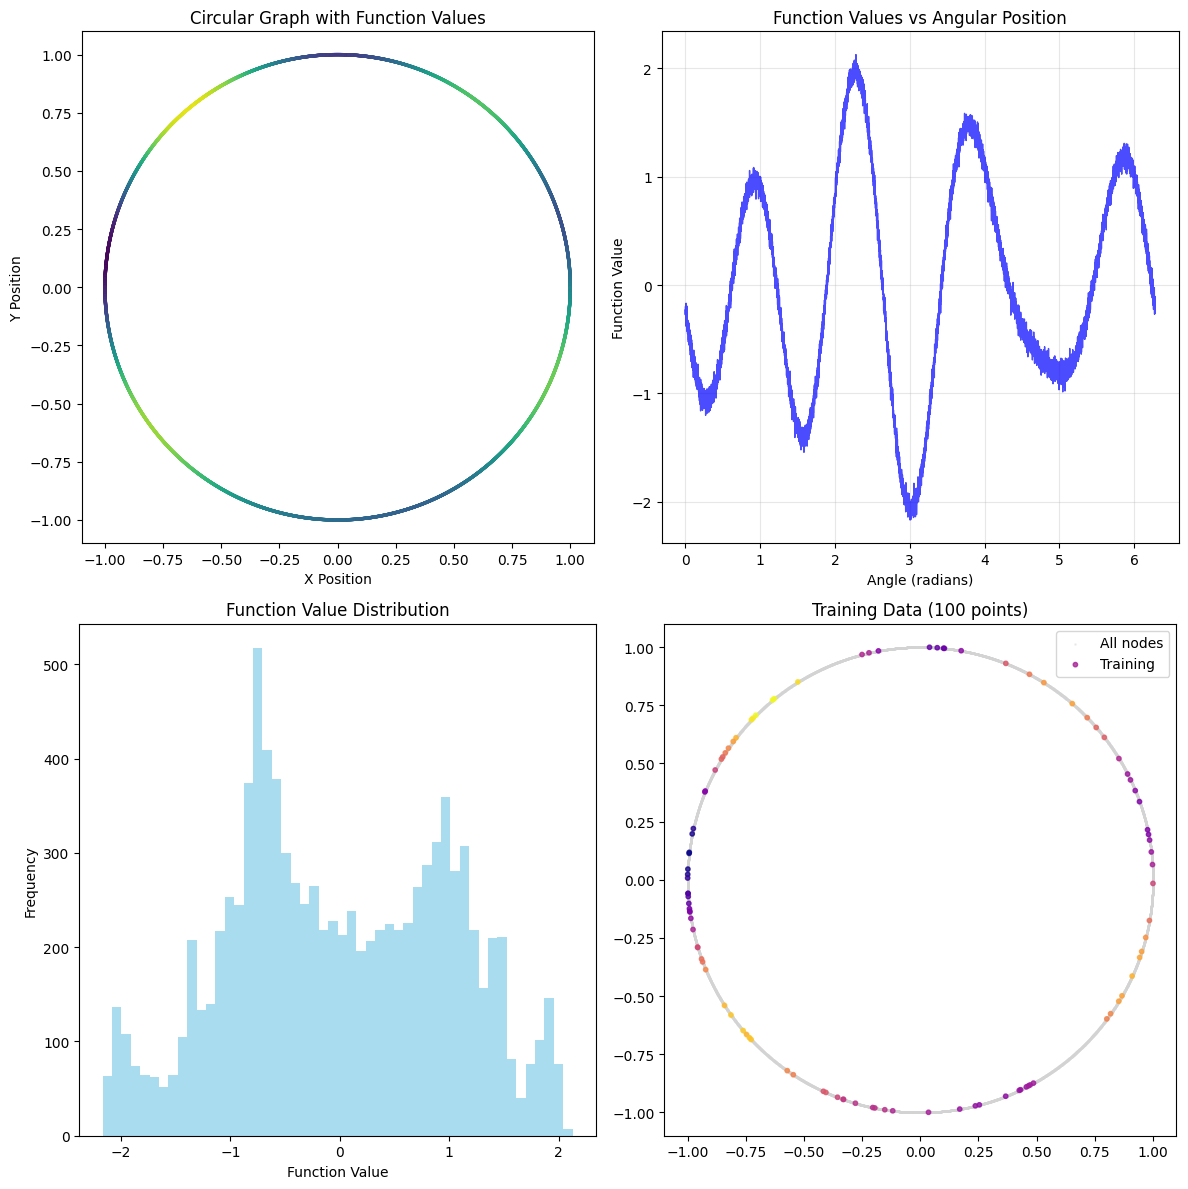


Graph statistics:
  Nodes: 10,000
  K-neighbors: 4 (degree = 8)
  Actual average degree: 8.00
  Graph density: 0.000800
  Is connected: True

Function statistics:
  Number of frequencies: 3
  Mean: 0.000000
  Std: 1.000000
  Range: [-2.168, 2.126]

Frequency components:
  Component 1: 4 cycles, amp=1.93, phase=4.60
  Component 2: 5 cycles, amp=1.40, phase=2.80
  Component 3: 3 cycles, amp=1.19, phase=2.10


In [3]:
# =============================================================================
# BUILD CIRCULAR GRAPH AND GENERATE DATA
# =============================================================================

print("Building circular graph and generating sinusoidal synthetic data...")
start_time = time.time()

# Build circular graph
A = build_circular_graph(N_NODES, K_NEIGHBORS)
print(f"Graph construction completed in {time.time() - start_time:.2f} seconds")
print(f"  Adjacency matrix shape: {A.shape}")
print(f"  Number of edges: {A.nnz:,}")
print(f"  Actual average degree: {A.nnz / N_NODES:.2f}")

# Generate circular sinusoidal function
y, coord_mapping, frequency_info = generate_circular_sinusoidal_function(N_NODES, N_FREQUENCIES, NOISE_STD)

# Normalize data
y_mean, y_std = np.mean(y), np.std(y)
y_normalized = (y - y_mean) / y_std

# Generate training data
X = np.arange(N_NODES)
n_training = int(N_NODES * TRAINING_RATIO)
X_train = np.sort(np.random.choice(N_NODES, size=n_training, replace=False))
y_train = y_normalized[X_train]

# Save dataset
np.savez('synthetic_circular_10k.npz',
         A_data=A.data, A_indices=A.indices, A_indptr=A.indptr, A_shape=A.shape,
         X=X, y=y_normalized, y_mean=y_mean, y_std=y_std,
         X_train=X_train, y_train=y_train, coord_mapping=coord_mapping,
         frequency_info=frequency_info, n_nodes=N_NODES, k_neighbors=K_NEIGHBORS,
         n_frequencies=N_FREQUENCIES, noise_std=NOISE_STD, 
         training_ratio=TRAINING_RATIO, random_seed=RANDOM_SEED)

print(f"\n✅ Circular graph dataset saved to 'synthetic_circular_10k.npz'")
print(f"✅ Nodes: {N_NODES:,}, Degree: {2*K_NEIGHBORS}, Training: {len(X_train):,}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Circular graph structure with function values
axes[0,0].scatter(coord_mapping[:, 0], coord_mapping[:, 1], 
                 c=y_normalized, cmap='viridis', s=2, alpha=0.8)
axes[0,0].set_title('Circular Graph with Function Values')
axes[0,0].set_xlabel('X Position')
axes[0,0].set_ylabel('Y Position')
axes[0,0].set_aspect('equal')

# Function values vs angular position
theta = np.linspace(0, 2*np.pi, N_NODES, endpoint=False)
axes[0,1].plot(theta, y_normalized, 'b-', alpha=0.7, linewidth=1)
axes[0,1].set_title('Function Values vs Angular Position')
axes[0,1].set_xlabel('Angle (radians)')
axes[0,1].set_ylabel('Function Value')
axes[0,1].grid(True, alpha=0.3)

# Function distribution
axes[1,0].hist(y_normalized, bins=50, alpha=0.7, color='skyblue')
axes[1,0].set_title('Function Value Distribution')
axes[1,0].set_xlabel('Function Value')
axes[1,0].set_ylabel('Frequency')

# Training data on circular graph
train_coords = coord_mapping[X_train]
axes[1,1].scatter(coord_mapping[:, 0], coord_mapping[:, 1], 
                 c='lightgray', s=1, alpha=0.3, label='All nodes')
axes[1,1].scatter(train_coords[:, 0], train_coords[:, 1], 
                 c=y_train, cmap='plasma', s=10, alpha=0.8, label='Training')
axes[1,1].set_title(f'Training Data ({len(X_train):,} points)')
axes[1,1].set_aspect('equal')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print(f"\nGraph statistics:")
print(f"  Nodes: {N_NODES:,}")
print(f"  K-neighbors: {K_NEIGHBORS} (degree = {2*K_NEIGHBORS})")
print(f"  Actual average degree: {A.nnz / N_NODES:.2f}")
print(f"  Graph density: {A.nnz / (N_NODES * (N_NODES - 1)):.6f}")
print(f"  Is connected: {nx.is_connected(nx.from_scipy_sparse_array(A))}")

print(f"\nFunction statistics:")
print(f"  Number of frequencies: {N_FREQUENCIES}")
print(f"  Mean: {np.mean(y_normalized):.6f}")
print(f"  Std: {np.std(y_normalized):.6f}")
print(f"  Range: [{np.min(y_normalized):.3f}, {np.max(y_normalized):.3f}]")

print(f"\nFrequency components:")
for i, freq_info in enumerate(frequency_info):
    print(f"  Component {i+1}: {freq_info['frequency']} cycles, amp={freq_info['amplitude']:.2f}, phase={freq_info['phase']:.2f}")